In [2]:
import os
import json
from PIL import Image
from pathlib import Path
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras_cv

c:\Users\carra\OneDrive\Escritorio\UNIVERSIDAD\SEPTIMO\IMAGENES Y VISION\PROYECTO\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# -----------------------------
# 1. Configuración básica
# -----------------------------
NUM_CLASSES = 5
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 8

# -----------------------------
# 2. Definir modelo RetinaNet
# -----------------------------
model = keras_cv.models.RetinaNet.from_preset(
    "resnet50",
    num_classes=NUM_CLASSES,
    bounding_box_format="xyxy"
)
model.backbone.trainable = False
model.summary()
model.compile(
    classification_loss="focal",
    box_loss="smoothl1",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

# -----------------------------
# 3. Funciones para cargar dataset YOLO
# -----------------------------
def load_yolo_annotation(txt_path, image_size):
    boxes, classes = [], []
    if not os.path.exists(txt_path):
        return np.array([], dtype=np.float32), np.array([], dtype=np.int32)
    with open(txt_path, "r") as f:
        for line in f:
            if line.strip() == "":
                continue
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, x, y, w, h = map(float, parts)
            x1 = (x - w / 2) * image_size[0]
            y1 = (y - h / 2) * image_size[1]
            x2 = (x + w / 2) * image_size[0]
            y2 = (y + h / 2) * image_size[1]
            boxes.append([x1, y1, x2, y2])
            classes.append(int(cls))
    return np.array(boxes, dtype=np.float32), np.array(classes, dtype=np.int32)

def load_dataset_from_yolo(images_dir, labels_dir, image_size=IMAGE_SIZE):
    image_paths = sorted([
        os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith(".jpg")
    ])
    def gen():
        for img_path in image_paths:
            ##print(f"cargando imagen {img_path}")
            img = Image.open(img_path).resize(image_size)
            img = np.array(img) / 255.0
            label_path = os.path.join(labels_dir, os.path.basename(img_path).replace(".jpg", ".txt"))
            ##print(f"cargando label {label_path}")
            boxes, classes = load_yolo_annotation(label_path, image_size)
            if boxes.shape[0] == 0:
                continue
            yield {
                "images": img.astype(np.float32),
                "bounding_boxes": {
                    "boxes": boxes,
                    "classes": classes
                }
            }
    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature={
            "images": tf.TensorSpec(shape=(image_size[0], image_size[1], 3), dtype=tf.float32),
            "bounding_boxes": {
                "boxes": tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
                "classes": tf.TensorSpec(shape=(None,), dtype=tf.int32)
            }
        }
    )
    dataset = dataset.padded_batch(
        BATCH_SIZE,
        padded_shapes={
            "images": [image_size[0], image_size[1], 3],
            "bounding_boxes": {
                "boxes": [None, 4],
                "classes": [None]
            }
        },
        padding_values={
            "images": 0.0,
            "bounding_boxes": {
                "boxes": 0.0,
                "classes": -1
            }
        },
        drop_remainder=True
    )
    return dataset.prefetch(tf.data.AUTOTUNE)

# -----------------------------
# 4. Cargar datasets
# -----------------------------
train_ds = load_dataset_from_yolo(
    "modelo_yolov11_dataset_completo/train/images",
    "modelo_yolov11_dataset_completo/train/labels"
).shuffle(100)

val_ds = load_dataset_from_yolo(
    "modelo_yolov11_dataset_completo/val/images",
    "modelo_yolov11_dataset_completo/val/labels"
)

# -----------------------------
# 5. Entrenar modelo (sin steps_per_epoch)
# -----------------------------
history = model.fit(train_ds, validation_data=val_ds, epochs=20, steps_per_epoch=250)


Model: "retina_net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer) │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, None,     │ 23,561,152 │ images[0][0]      │
│ (Functional)        │ None, 512),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 1024),      │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 2048)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_pyramid     │ [(None, None,     │  7,997,440 │ functional[0][0], │
│ (FeaturePyramid)    │ None, 256),       │            │ functional[0][1], │
│                     │ (None, None,      │            │ functional[0][2]  │
│                     │ None, 256),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 256),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 256),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 256)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prediction_head_1   │ (None, None,      │  1,853,220 │ feature_pyramid[… │
│ (PredictionHead)    │ None, 36)         │            │ feature_pyramid[… │
│                     │                   │            │ feature_pyramid[… │
│                     │                   │            │ feature_pyramid[… │
│                     │                   │            │ feature_pyramid[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prediction_head     │ (None, None,      │  1,873,965 │ feature_pyramid[… │
│ (PredictionHead)    │ None, 45)         │            │ feature_pyramid[… │
│                     │                   │            │ feature_pyramid[… │
│                     │                   │            │ feature_pyramid[… │
│                     │                   │            │ feature_pyramid[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, None, 4)   │          0 │ prediction_head_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, None, 4)   │          0 │ prediction_head_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, None, 4)   │          0 │ prediction_head_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, None, 4)   │          0 │ prediction_head_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, None, 4)   │          0 │ prediction_head_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, None, 5)   │          0 │ prediction_head[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, None, 5)   │          0 │ prediction_head[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, None, 5)   │          0 │ prediction_head[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 35,285,777 (134.60 MB)

 Trainable params: 11,724,625 (44.73 MB)

 Non-trainable params: 23,561,152 (89.88 MB)

Epoch 1/20


c:\Users\carra\OneDrive\Escritorio\UNIVERSIDAD\SEPTIMO\IMAGENES Y VISION\PROYECTO\venv\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'images': 'images'}
Received: inputs=Tensor(shape=(8, 512, 512, 3))
  warnings.warn(msg)
c:\Users\carra\OneDrive\Escritorio\UNIVERSIDAD\SEPTIMO\IMAGENES Y VISION\PROYECTO\venv\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(8, 512, 512, 3))
  warnings.warn(msg)


250/250 ━━━━━━━━━━━━━━━━━━━━ 2399s 9s/step - box_loss: 0.6549 - classification_loss: 1.1282 - loss: 1.7831 - val_box_loss: 0.6719 - val_classification_loss: 1.9311 - val_loss: 2.6030
Epoch 2/20


c:\Users\carra\OneDrive\Escritorio\UNIVERSIDAD\SEPTIMO\IMAGENES Y VISION\PROYECTO\venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


250/250 ━━━━━━━━━━━━━━━━━━━━ 2332s 9s/step - box_loss: 0.7004 - classification_loss: 1.8287 - loss: 2.5290 - val_box_loss: 0.6582 - val_classification_loss: 1.0131 - val_loss: 1.6712
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2199s 9s/step - box_loss: 0.6651 - classification_loss: 0.8155 - loss: 1.4806 - val_box_loss: 0.6476 - val_classification_loss: 0.8989 - val_loss: 1.5465
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 482s 2s/step - box_loss: 0.5876 - classification_loss: 0.6935 - loss: 1.2811 - val_box_loss: 0.6216 - val_classification_loss: 0.9232 - val_loss: 1.5448
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2153s 8s/step - box_loss: 0.6286 - classification_loss: 1.0417 - loss: 1.6703 - val_box_loss: 0.6761 - val_classification_loss: 1.3764 - val_loss: 2.0525
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2025s 8s/step - box_loss: 0.6714 - classification_loss: 1.0500 - loss: 1.7214 - val_box_loss: 0.6346 - val_classification_loss: 1.0967 - val_loss: 1.7312
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20

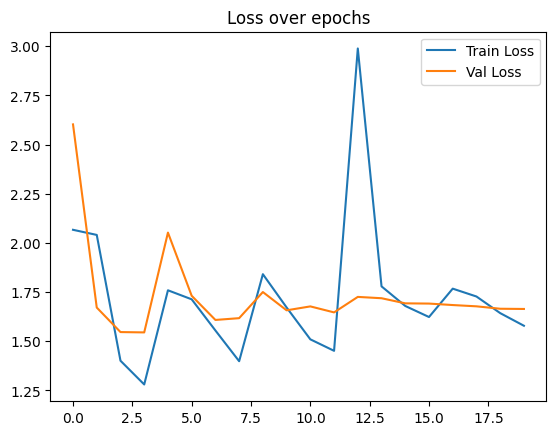

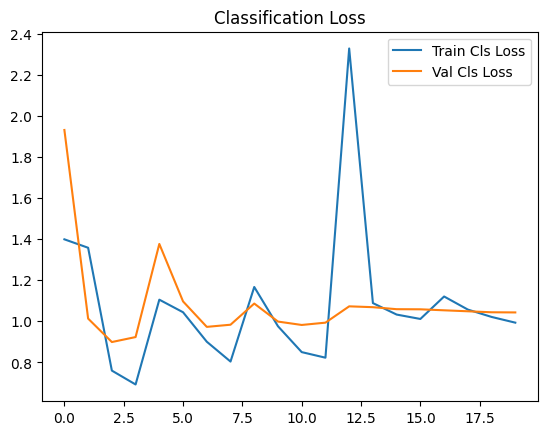

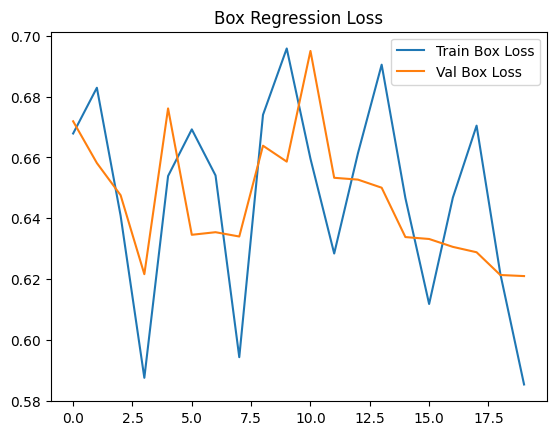

In [6]:
# -----------------------------
# 6. Visualizar pérdidas
# -----------------------------
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()

plt.plot(history.history['classification_loss'], label='Train Cls Loss')
plt.plot(history.history['val_classification_loss'], label='Val Cls Loss')
plt.legend()
plt.title("Classification Loss")
plt.show()

plt.plot(history.history['box_loss'], label='Train Box Loss')
plt.plot(history.history['val_box_loss'], label='Val Box Loss')
plt.legend()
plt.title("Box Regression Loss")
plt.show()

In [15]:
def load_image_for_prediction(image_path, image_size=IMAGE_SIZE):
    image = Image.open(image_path).convert("RGB").resize(image_size)
    img_array = np.array(image) / 255.0
    return img_array.astype(np.float32), image

image_array, original_image = load_image_for_prediction("aug_class0_video_11min_466_1936_9725.jpg")
image_batch = np.expand_dims(image_array, axis=0)  # (1, H, W, 3)

predictions = model.predict(image_batch)
print(predictions)


##draw_predictions(original_image, predictions[0]) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
{'boxes': array([[[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., 

In [16]:
val_ds_raw = load_dataset_from_yolo(
    "modelo_yolov11_dataset_completo/val/images",
    "modelo_yolov11_dataset_completo/val/labels"
)

for sample in val_ds_raw.take(2):
    print("Boxes:", sample["bounding_boxes"]["boxes"])
    print("Classes:", sample["bounding_boxes"]["classes"])

Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []


In [18]:
# -----------------------------
# 1. Configuración básica
# -----------------------------
NUM_CLASSES = 5
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 8

# -----------------------------
# 2. Definir modelo RetinaNet
# -----------------------------
model1 = keras_cv.models.RetinaNet.from_preset(
    "resnet50",
    num_classes=NUM_CLASSES,
    bounding_box_format="xyxy"
)
model1.backbone.trainable = False
model1.summary()
model1.compile(
    classification_loss="focal",
    box_loss="smoothl1",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

# -----------------------------
# 4. Cargar datasets
# -----------------------------
train_ds1 = load_dataset_from_yolo(
    "modelo_yolov11_dataset_filtrado/train/images",
    "modelo_yolov11_dataset_filtrado/train/labels"
).shuffle(100)

val_ds1 = load_dataset_from_yolo(
    "modelo_yolov11_dataset_filtrado/val/images",
    "modelo_yolov11_dataset_filtrado/val/labels"
)

# -----------------------------
# 5. Entrenar modelo (sin steps_per_epoch)
# -----------------------------
history1 = model1.fit(train_ds1, validation_data=val_ds1, epochs=20, steps_per_epoch=250)


Model: "retina_net_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer) │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ [(None, None,     │ 23,561,152 │ images[0][0]      │
│ (Functional)        │ None, 512),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 1024),      │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 2048)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_pyramid_1   │ [(None, None,     │  7,997,440 │ functional_1[0][… │
│ (FeaturePyramid)    │ None, 256),       │            │ functional_1[0][… │
│                     │ (None, None,      │            │ functional_1[0][… │
│                     │ None, 256),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 256),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 256),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 256)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prediction_head_3   │ (None, None,      │  1,853,220 │ feature_pyramid_… │
│ (PredictionHead)    │ None, 36)         │            │ feature_pyramid_… │
│                     │                   │            │ feature_pyramid_… │
│                     │                   │            │ feature_pyramid_… │
│                     │                   │            │ feature_pyramid_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prediction_head_2   │ (None, None,      │  1,873,965 │ feature_pyramid_… │
│ (PredictionHead)    │ None, 45)         │            │ feature_pyramid_… │
│                     │                   │            │ feature_pyramid_… │
│                     │                   │            │ feature_pyramid_… │
│                     │                   │            │ feature_pyramid_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_10          │ (None, None, 4)   │          0 │ prediction_head_… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, None, 4)   │          0 │ prediction_head_… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_14          │ (None, None, 4)   │          0 │ prediction_head_… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_16          │ (None, None, 4)   │          0 │ prediction_head_… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_18          │ (None, None, 4)   │          0 │ prediction_head_… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_11          │ (None, None, 5)   │          0 │ prediction_head_

 Total params: 35,285,777 (134.60 MB)

 Trainable params: 11,724,625 (44.73 MB)

 Non-trainable params: 23,561,152 (89.88 MB)

Epoch 1/20


c:\Users\carra\OneDrive\Escritorio\UNIVERSIDAD\SEPTIMO\IMAGENES Y VISION\PROYECTO\venv\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'images': 'images'}
Received: inputs=Tensor(shape=(8, 512, 512, 3))
  warnings.warn(msg)
c:\Users\carra\OneDrive\Escritorio\UNIVERSIDAD\SEPTIMO\IMAGENES Y VISION\PROYECTO\venv\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_251']
Received: inputs=Tensor(shape=(8, 512, 512, 3))
  warnings.warn(msg)


Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []
Classes: []
Boxes: []


c:\Users\carra\OneDrive\Escritorio\UNIVERSIDAD\SEPTIMO\IMAGENES Y VISION\PROYECTO\venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Boxes: [[ 52.61952 312.1728  272.4319  511.99976]
 [253.8048  190.56767 511.99976 351.2256 ]]
Classes: [3 3]
Boxes: [[348.18253  287.01465  510.85825  453.12537 ]
 [  6.278656 211.31853  345.8995   346.94067 ]]
Classes: [3 3]
Boxes: [[  1.14176 287.01465 163.81747 453.12537]
 [166.10048 211.31853 505.72134 346.94067]]
Classes: [3 3]
Boxes: [[  1.14176 287.01465 163.81747 453.12537]
 [166.10048 211.31853 505.72134 346.94067]]
Classes: [3 3]
Boxes: [[341.17554  287.63058  511.99976  511.99976 ]
 [ 49.577473 246.18752  341.2905   329.59744 ]]
Classes: [3 3]
Boxes: [[ 37.425407 289.68524  276.60468  512.00024 ]
 [270.49985  223.31238  512.       333.1753  ]]
Classes: [3 3]
Boxes: [[  1.712384 249.16634  208.33868  445.76614 ]
 [211.19283  213.4208   414.39438  280.7063  ]
 [414.9655   220.78003  508.0046   314.34906 ]]
Classes: [3 3 3]
Boxes: [[  1.712384 249.16634  208.33868  445.76614 ]
 [211.19283  213.4208   414.39438  280.7063  ]
 [414.9655   220.78003  508.0046   314.34906 ]]
Classes

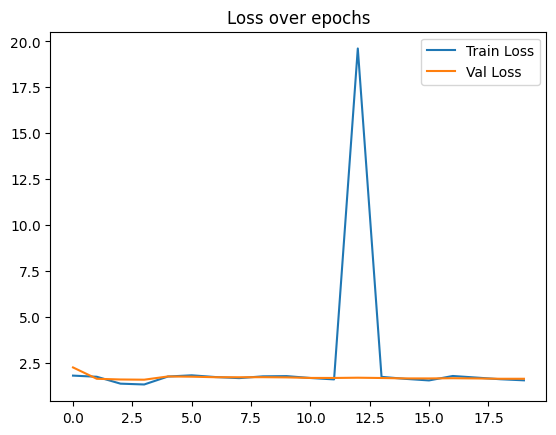

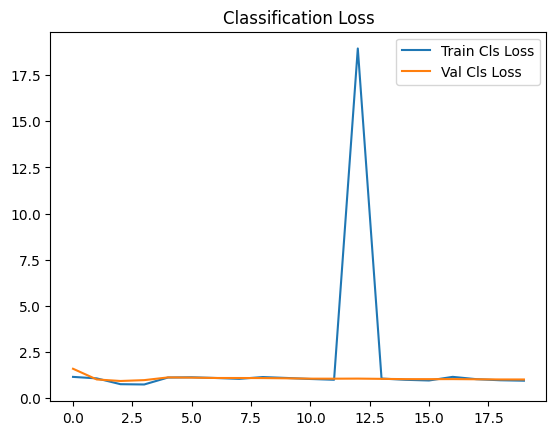

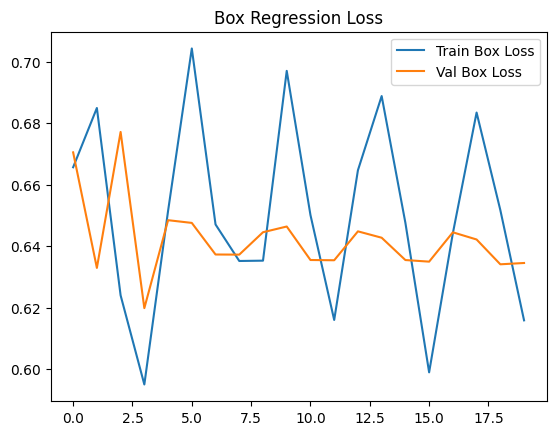

In [19]:
# -----------------------------
# 6. Visualizar pérdidas
# -----------------------------
plt.plot(history1.history["loss"], label="Train Loss")
plt.plot(history1.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()

plt.plot(history1.history['classification_loss'], label='Train Cls Loss')
plt.plot(history1.history['val_classification_loss'], label='Val Cls Loss')
plt.legend()
plt.title("Classification Loss")
plt.show()

plt.plot(history1.history['box_loss'], label='Train Box Loss')
plt.plot(history1.history['val_box_loss'], label='Val Box Loss')
plt.legend()
plt.title("Box Regression Loss")
plt.show()

In [24]:
def load_image_for_prediction(image_path, image_size=IMAGE_SIZE):
    image = Image.open(image_path).convert("RGB").resize(image_size)
    img_array = np.array(image) / 255.0
    return img_array.astype(np.float32), image

image_array, original_image = load_image_for_prediction("aug_class4_video_11min_115_2433_4266.jpg")
image_batch = np.expand_dims(image_array, axis=0)  # (1, H, W, 3)

predictions = model1.predict(image_batch)
print(predictions)


##draw_predictions(original_image, predictions[0]) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
{'boxes': array([[[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., 